In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import re
from pyteomics import parser
import itertools as it
from pyseq_align import NeedlemanWunsch
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Map *de novo* peptides

In this notebook we will map the *de novo* peptides to the BLG sequence.
We divide this in:
1. Read data *de novo* data and BLG sequences
1.2. Blind sequence
2. Create BLG indices
    - a) Full peptide index. 7-25 length
    - b) k-mer index. k=3 to k=5
3. Process *de novo* data
2.2. Keep best scoring PSM per spectra
2.3. Keep peptides with length 7-25
4. Match *de novo* peptides to full peptide index
5. Map *de novo* peptides to BLG using kmer index
5.1. Match C and N-term *de novo* kmers to k-mer index
5.2. Extract BLG sequence from matched kmer
5.3. Needlemann-Wunsch alignment between *de novo* peptide and extracted BLG
5.4. Select best alignemnt
6. Expand peptide positions
7. Pivot to long format
    7.1. Calculate accuracy and coverage
8. Plotting
   - Overall accuracy by Run, Sample y k-mer side
   - Accuracy by relative peptide position by Run and k-mer side
   - The accuracy and coverage plots use stacked bar plots, which is not well supported in Seaborn,
     so we will export the data and load it in R




In [3]:
project = '/home/ismael/palaeoproteomics/BLG'

# Read data *de novo* data and BLG sequences

In [4]:
denovo_data = os.path.join(project, 'analysis_results/denovo_psms_data.csv')
denovo_psms_data = pd.read_csv(denovo_data)

bovin_blg_file = os.path.join(
    project,
    'bovin_blg/bovin_blg.fasta'
)

rec_iter = SeqIO.parse(bovin_blg_file, format='fasta')

### Blind sequences

In [5]:

li_regex = re.compile(r'[LI]')
nd_regex = re.compile(r'[ND]')
qe_regex = re.compile(r'[QE]')

denovo_psms_data['BlindSeq'] = denovo_psms_data['Seq'].str.replace(li_regex, 'B', regex=True)
denovo_psms_data['BlindSeq'] = denovo_psms_data['BlindSeq'].str.replace(nd_regex, 'X', regex=True)
denovo_psms_data['BlindSeq'] = denovo_psms_data['BlindSeq'].str.replace(qe_regex, 'Z', regex=True)

bovin_blg_blind = dict()
for rec in SeqIO.parse(bovin_blg_file, format='fasta'):
    a = li_regex.sub('B', str(rec.seq))
    a = nd_regex.sub('X', a)
    a = qe_regex.sub('Z', a)
    a = Seq(a)
    blind_rec = SeqRecord(id=rec.id, seq=a, description=rec.description, name=rec.name)
    bovin_blg_blind[rec.id] = [rec, blind_rec]

# BLG sequence Indiex
- a) Index of peptides of length 7 to 25.
- b) k-mer index. Length 3 to 5

### Peptide index

In [6]:
sequences = []
for r, br in bovin_blg_blind.values():
    digested = parser.icleave(
        str(br.seq),
        rule = '',
        missed_cleavages = 25,
        min_length = 7, max_length=25)
    digested = list(digested)
    # Make unique
    uniq_idx = np.unique([s[1] for s in digested], return_index=True)[1]
    digested_uniq = [(digested[i][0], digested[i][1], r.id) for i in uniq_idx]
    sequences = it.chain(sequences, digested_uniq)

sequences = list(sequences)


Create the actual index: a dictionary with keys each of the window slices.
The values are a list of tuples containing the protein IDs and positions from which the slice is originated

In [7]:
pep_index = {}
# 'XXXXXXXX': [(id, pos), (id, pos), ...],
# ....
for i in range(len(sequences)):
    if sequences[i][1] not in pep_index:
        pep_index[sequences[i][1]] = [(sequences[i][2], sequences[i][0])]
    else:
        pep_index[sequences[i][1]].append((sequences[i][2], sequences[i][0]))


In [8]:
len(pep_index)

4009

### Kmer index

In [9]:
# First digest sequences
kmers = []
for r, br in bovin_blg_blind.values():
    digested = parser.xcleave(
        str(br.seq),
        rule = '',
        missed_cleavages = 5,
        min_length = 3, max_length=5)
    digested = [(d[0], d[1], r.id) for d in digested]
    kmers = it.chain(kmers, digested)
kmers = list(kmers)
# Pyteomics icleave has a bug, that the peptides generated at position 0 are repeated
kmers_uniq_idx = np.unique(kmers, axis=0, return_index=True)[1]
kmers_uniq = [(kmers[i][0], kmers[i][1], kmers[i][2]) for i in kmers_uniq_idx]

Create the actual index: a dictionary with keys each of the window slices.
The values are a list of tuples containing the protein IDs and positions from which the slice is originated

In [10]:
# Create kmer index
kmer_index = {}
for i in range(len(kmers_uniq)):
    if kmers_uniq[i][1] not in kmer_index:
        kmer_index[kmers_uniq[i][1]] = [((kmers_uniq[i][2]), kmers_uniq[i][0])]
    else:
        kmer_index[kmers_uniq[i][1]].append((kmers_uniq[i][2], kmers_uniq[i][0]))


# Process *de novo* data

In [11]:
# Read becnchmark table
benchmark_table_runs = pd.read_csv(os.path.join(project, 'benchmark_table.csv'))


Remove duplicates by Scan No

In [12]:
denovo_psms_data = denovo_psms_data.drop_duplicates(subset=['Run_id', 'Sample', 'Scan_No', 'Seq'], keep='first')
denovo_psms_data['seq_length'] = denovo_psms_data['Seq'].str.len()
denovo_psms_data

,Sample,Scan_No,RTsec,ModSeq,Seq,score,Run_id,calc_mass,delta_mass,Search,Engine,Digestion,DB,Pep_length,FDR,System,Run settings,BlindSeq,seq_length
0,N1280,5509,1059.951348,NH2-PM<ox>HLLR-COOH,PMHLLR,69.900,novor_db1,783.441432,0.001540,de novo,Novor,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),Novor DB1,PMHBBR,6
1,N1280,7176,1308.120325,NH2-KQQPLR-COOH,KQQPLR,59.300,novor_db1,770.475174,-0.008743,de novo,Novor,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),Novor DB1,KZZPBR,6
2,N1280,7752,1393.771134,NH2-EMVLEEVMLR-COOH,EMVLEEVMLR,51.100,novor_db1,1250.647210,0.015981,de novo,Novor,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),Novor DB1,ZMVBZZVMBR,10
3,N1280,10202,1758.383226,NH2-LLLEGDR-COOH,LLLEGDR,54.200,novor_db1,816.469420,0.006587,de novo,Novor,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),Novor DB1,BBBZGXR,7
4,N1280,5172,1009.864349,NH2-PELLAEK-COOH,PELLAEK,72.900,novor_db1,800.463272,0.000966,de novo,Novor,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),Novor DB1,PZBBAZK,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82130,N0040,3973,923.971642,NH2-PMGHLR-COOH,PMGHLR,60.099,pepnovo_db2,711.383917,-0.002371,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,PMGHBR,6
82131,N0040,1590,504.423060,NH2-KLRWR-COOH,KLRWR,8.116,pepnovo_db2,759.485680,-0.002799,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,KBRWR,5
82132,N0040,1590,504.423060,NH2-KLWRR-COOH,KLWRR,6.762,pepnovo_db2,759.485680,-0.002799,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,KBWRR,5
82133,N0040,4698,1032.017038,NH2-LPMLGHR-COOH,LPMLGHR,48.837,pepnovo_db2,824.467981,-0.002454,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,BPMBGHR,7


When the same software has multiple PSMs for the same spectra, choose the best
Create a temp score, to change DirectTag score sign, so higher is better for all
- DirecTag score is expectation. Lower is better
- PepNovo is rank score. Higher is better
- pNovo+ is graph score. Higher is better
- Novor is score from decision trees and machinelearning on spectral libs. Higher is better

In [13]:
denovo_psms_data['score_tmp'] = denovo_psms_data.loc[:, 'score']
denovo_psms_data.loc[denovo_psms_data['Engine'] == 'DirectTag', 'score_tmp'] = \
    - denovo_psms_data.loc[denovo_psms_data['Engine'] == 'DirectTag', 'score_tmp']
denovo_psms_data = (
    denovo_psms_data.groupby(['Run_id', 'Sample', 'Scan_No'], as_index=False)
    .apply(lambda x: x.iloc[np.argmax(x['score_tmp']),:])
)
denovo_psms_data.shape

(63739, 20)

In [14]:
denovo_psms_data

,Sample,Scan_No,RTsec,ModSeq,Seq,score,Run_id,calc_mass,delta_mass,Search,Engine,Digestion,DB,Pep_length,FDR,System,Run settings,BlindSeq,seq_length,score_tmp
0,N0000,1334,430.816443,NH2-IIAEKTK-COOH,IIAEKTK,0.000078,directag_db1,803.510557,-0.001767,de novo,DirecTag,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),DirecTag DB1,BBAZKTK,7,0.000078
1,N0000,1352,436.135259,NH2-SSGGSIGGRG-COOH,SSGGSIGGRG,0.000002,directag_db1,835.413696,-0.001309,de novo,DirecTag,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),DirecTag DB1,SSGGSBGGRG,10,0.000002
2,N0000,1388,446.533596,NH2-KIIAEK-COOH,KIIAEK,0.000000,directag_db1,702.462878,-0.000482,de novo,DirecTag,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),DirecTag DB1,KBBAZK,6,0.000000
3,N0000,1481,467.497105,NH2-KIIAEK-COOH,KIIAEK,0.000000,directag_db1,702.462878,-0.001550,de novo,DirecTag,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),DirecTag DB1,KBBAZK,6,0.000000
4,N0000,1554,488.387422,NH2-KIIAEK-COOH,KIIAEK,0.000000,directag_db1,702.462878,-0.000884,de novo,DirecTag,Novo,DB1,Novo,1.0,MiniMax (DeNovoGUI),DirecTag DB1,KBBAZK,6,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63734,N1280,12292,2069.336975,NH2-GRLFYK-COOH,GRLFYK,10.025000,pepnovo_db2,784.458462,-0.002709,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,GRBFYK,6,10.025000
63735,N1280,12334,2075.618946,NH2-VLLCFK-COOH,VLLCFK,57.651000,pepnovo_db2,724.437576,56.036966,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,VBBCFK,6,57.651000
63736,N1280,12392,2084.882404,NH2-VLVSHR-COOH,VLVSHR,54.514000,pepnovo_db2,711.438061,0.014066,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,VBVSHR,6,54.514000
63737,N1280,12420,2088.958530,NH2-EQFTQR-COOH,EQFTQR,20.153000,pepnovo_db2,810.405424,-0.023695,de novo,PepNovo+,Novo,DB2,Novo,1.0,MiniMax (DeNovoGUI),PepNovo+ DB2,ZZFTZR,6,20.153000


We're going to filter out peptides shorter than 5 and longer than 25

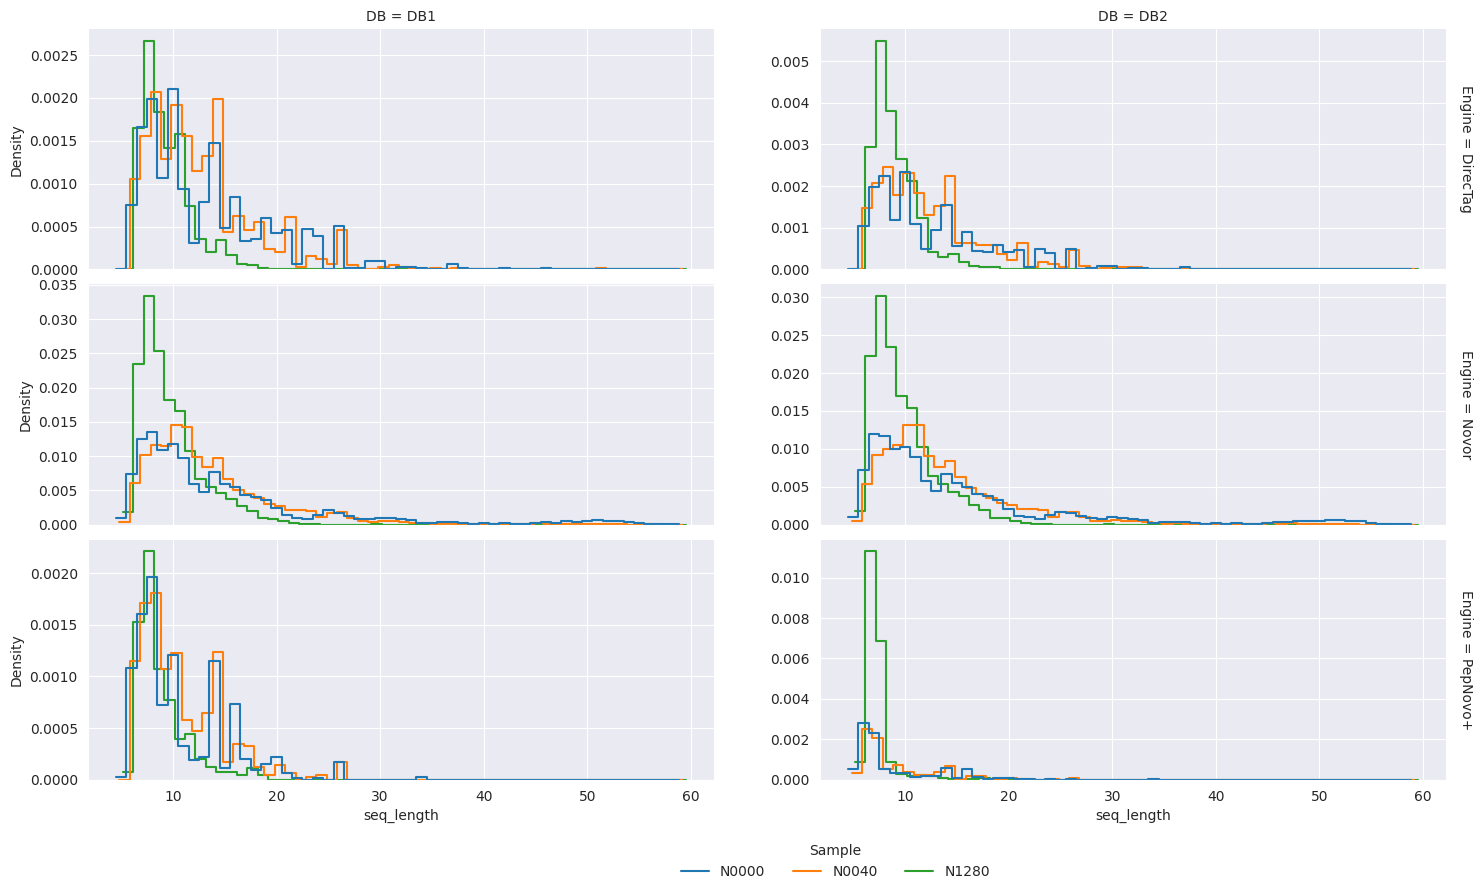

In [16]:
denovo_psms_data['seq_length'] = denovo_psms_data['Seq'].str.len()
p1 = sns.displot(denovo_psms_data, x='seq_length', kind='hist', col='DB', row='Engine', hue='Sample', discrete=True,
                 stat='density', element='step', fill=False, multiple='dodge', facet_kws=dict(sharey=False, margin_titles=True))
p1.tight_layout()
p1.figure.set_size_inches((18,8))
for ax in p1.axes.flatten():
    ax.set_xticks([10, 20, 30, 40, 50, 60], [10, 20, 30, 40, 50, 60])
sns.move_legend(p1, 'lower center', bbox_to_anchor=(0.5, -0.1),  ncols=3)
plt.show()
plt.close()

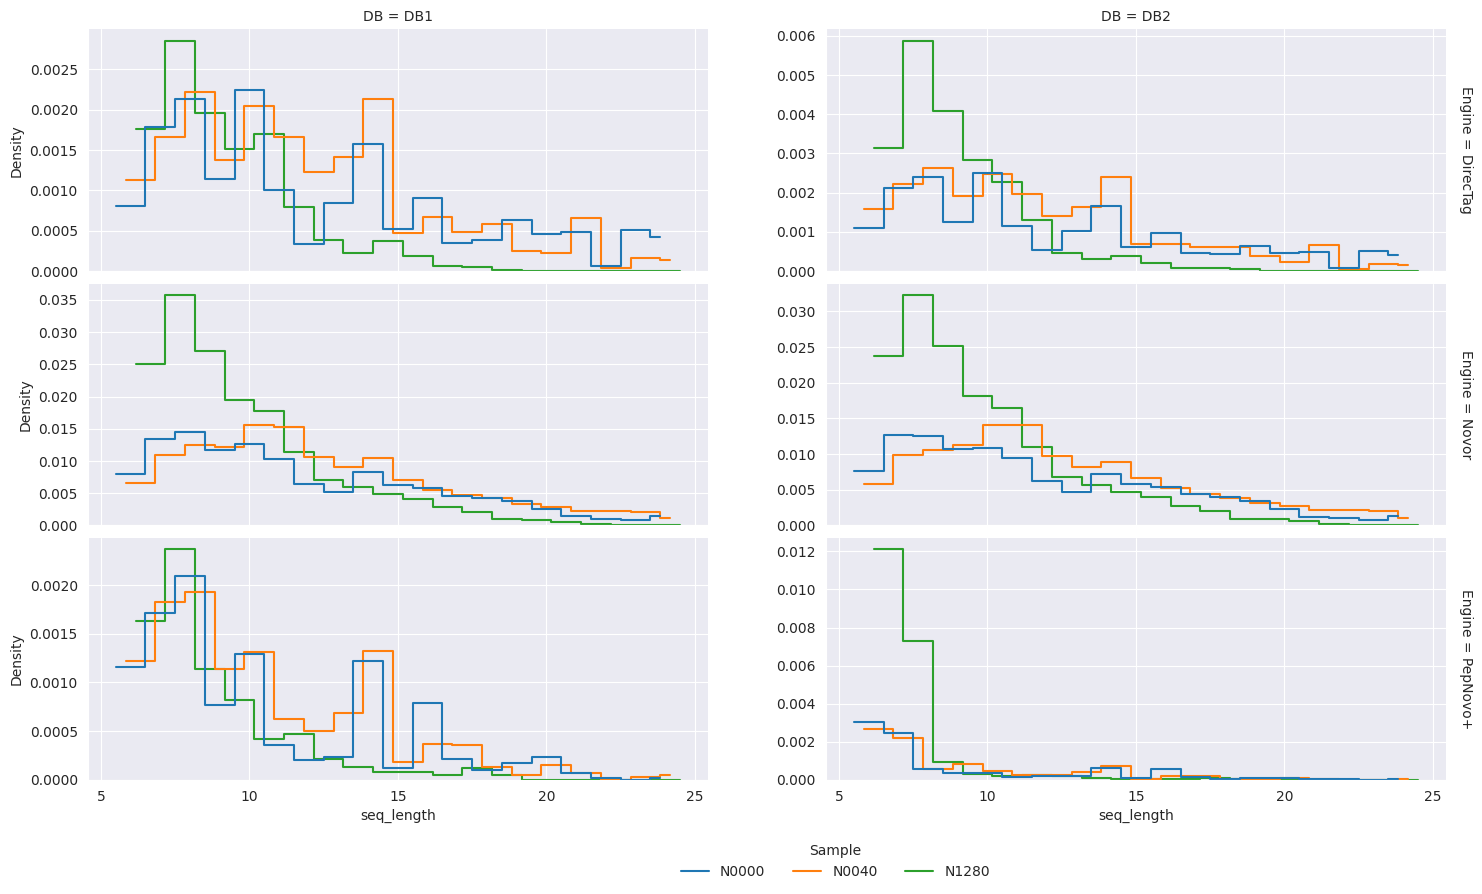

In [67]:
denovo_psms_data = denovo_psms_data.loc[
    (denovo_psms_data['Seq'].str.len() < 25)
    & (denovo_psms_data['Seq'].str.len() > 5), :].copy()

p2 = sns.displot(denovo_psms_data, x='seq_length', kind='hist', col='DB', row='Engine', hue='Sample', discrete=True,
                 stat='density', element='step', fill=False, multiple='dodge', facet_kws=dict(sharey=False, margin_titles=True))
p2.tight_layout()
p2.figure.set_size_inches((18, 8))
for ax in p2.axes.flatten():
    ax.set_xticks([5,10,15,20,25], [5,10,15,20,25])
        
sns.move_legend(p2, 'lower center', bbox_to_anchor=(0.5, -0.1), ncols=3)
plt.show()
plt.close()

In [65]:
p2.axes

array([[<Axes: title={'center': 'DB = DB1'}, ylabel='Density'>,
        <Axes: title={'center': 'DB = DB2'}>],
       [<Axes: ylabel='Density'>, <Axes: >],
       [<Axes: xlabel='seq_length', ylabel='Density'>,
        <Axes: xlabel='seq_length'>]], dtype=object)

# Match to full peptide index

Using the peptide index, find exact matches between *de novo* peptides and BLG.

For each software, find the number of *de novo* peptides that have exact matches to a BLG peptide

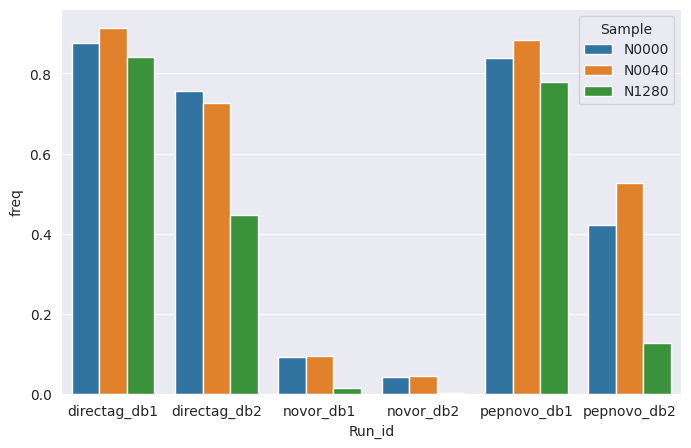

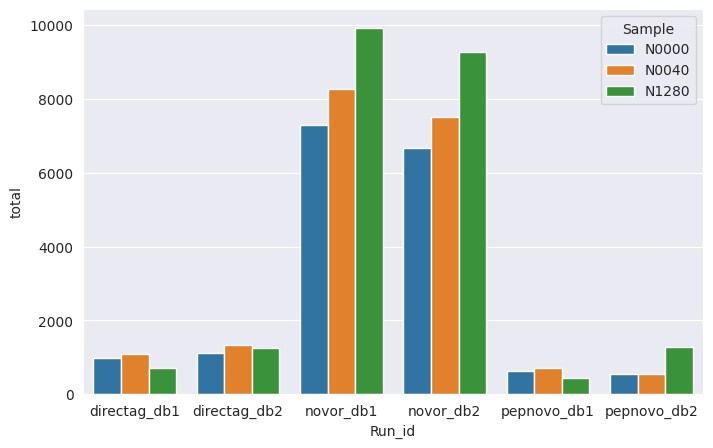

In [16]:
denovo_psms_data['match'] = denovo_psms_data['BlindSeq'].apply(lambda x: x in pep_index)

exact_matches = denovo_psms_data.groupby(['Run_id', 'Sample'])['match'].agg(
    freq=lambda x: x.sum()/len(x),
    total=lambda x: len(x)
)
exact_matches = exact_matches.reset_index()

ax1 = sns.barplot(data=exact_matches, x='Run_id', y='freq', hue='Sample')
ax1.get_figure().set_size_inches((8, 5))
plt.show()
plt.close()
ax2 = sns.barplot(data=exact_matches, x='Run_id', y='total', hue='Sample')
ax2.get_figure().set_size_inches((8, 5))
plt.show()
plt.close()

Novor finds more PSMs, but out of those, only small percentage fraction have a perfect match to BLG

# Map *de novo* peptides to BLG

Here we use the BLG kmer index

### Find *candidate* sequences
1. For each peptide extract C and N terminal k-mers in descending order $k_{max}, k_{max}-1, ..., k_{min}$
    In our case, $k_{max}=5$ and $k_{min}=3$
2. Search in BLG k-mer index
3. Extract BLG sequences using matched k-mers positions. The BLG sequences have the same length as the *de novo* or we can use an offset to have slightly longer sequences.
    These are *candidate* sequences that will be aligned to the *de novo* peptide

In [17]:
def map_denovo(denovopeps, kmax, kmin, kmer_index, bovin_blg, offset=2):
    candidate_seqs = []
    for pepseq in denovopeps:
        seqs_to_align = {}
        k = kmax
        while k >= kmin:
            kmerC = kmer_index.get(pepseq[-k:], None)
            kmerN = kmer_index.get(pepseq[:k], None)
            if kmerN is None and kmerC is None:
                k -= 1
                continue
            if kmerC is not None:
                for i in range(len(kmerC)):
                    kmerC_i = kmerC[i]
                    posC = kmerC_i[1] + k - len(pepseq) - offset
                    subjectC = bovin_blg[kmerC_i[0]][1][posC:kmerC_i[1]+k].seq
                    subjectC = str(subjectC)

                    # print(f'kmer pos: {k} C-term. Hit {i}')
                    # print(f'\t{pepseq}\n\t{subjectC}')
                    if subjectC not in seqs_to_align:
                        seqs_to_align[subjectC] = [(k, 'C', kmerC_i[0], posC)]
                    else:
                        for sub in seqs_to_align[subjectC]:
                            if (sub[2] == kmerC_i[0] and sub[3] == posC
                                    and sub[1] == 'C' and sub[0] >= k):
                                break
                        else:
                            seqs_to_align[subjectC].append((k, 'C', kmerC_i[0], posC))
            if kmerN is not None:
                for i in range(len(kmerN)):
                    kmerN_i = kmerN[i]
                    posN = kmerN_i[1]
                    subjectN = bovin_blg[kmerN_i[0]][1][posN:kmerN_i[1]+len(pepseq)+offset].seq
                    subjectN = str(subjectN)
                    # print(f'kmer pos: {k} N-term. Hit {i}')
                    # print(f'\t{pepseq}\n\t{subjectN}')
                    if subjectN not in seqs_to_align:
                        seqs_to_align[subjectN] = [(k, 'N', kmerN_i[0], posN)]
                    else:
                        for sub in seqs_to_align[subjectN]:
                            if (sub[2] == kmerN_i[0] and sub[3] == posN
                                    and sub[1] == 'N' and sub[0] >= k):
                                break
                        else:
                            seqs_to_align[subjectN].append((k, 'N', kmerN_i[0], posN))
            # if kmerN is not None or kmerC is not None:
            #     break
            k -= 1
        candidate_seqs.append((pepseq, seqs_to_align))
    return candidate_seqs

In [18]:
kmin = 3
kmax = 5
offset = 0
denovopeps = denovo_psms_data['BlindSeq'].values
candidates = map_denovo(denovopeps, kmax, kmin, kmer_index, bovin_blg_blind, offset=offset)

### Align candidate sequences and select best

1. Align each *de novo* peptide to its candidates.
    We use the Needleman-Wunsch sequence alignment. In the alignment "*Queries*" are  the *de novo* peptides and "*subjects*" the BLG peptides
2. Select best based in identity


In [19]:

nw = NeedlemanWunsch(
    match=2, mismatch=-2, gap_open=-2, gap_extend=-2
)

def get_id_bypos(seq_a, seq_b):
    eq_vec = [1 if a == b else 0 for a, b in zip(seq_a, seq_b)]
    return np.array(eq_vec)


In [20]:
def remove_terminal_gaps(nterm_run, cterm_run, q_al, s_al, side):
    if side == 'C':
        m = nterm_run.search(q_al)
    else: # side == 'N'
        m = cterm_run.search(s_al)

    if m is not None:
        n_run = len(m[0])
    else:
        n_run = 0

    if side == 'C':
        q_al = q_al[n_run:]
        s_al = s_al[n_run:]
    else: # side == 'N'
        q_al = q_al[:len(q_al)-n_run]
        s_al = s_al[:len(s_al)-n_run]
    return q_al, s_al

def get_best_aligns(candidates, minid=0.5, idtol=5, remove_term_gaps=True):
    best_aligns = []

    nterm_run = re.compile(f'^-+')
    cterm_run = re.compile(f'-+$')
    for pseq_entry in candidates:
        query = pseq_entry[0]
        cand_subs = pseq_entry[1]
        best_id = np.nan
        best_side = 'N'
        # [query, best_id, best_side, best_id_bypos, best_s_al, best_q_al, prot_pos]
        new_row = [query, best_id, best_side, [], None, None, pd.NA]
        for sub, sub_data in cand_subs.items():
            al = nw.align(query, sub)
            q_al, s_al = al.result_a, al.result_b
            side = sub_data[0][1] # Pick side from first
            prot_pos = sub_data[0][3] # + 1
            # Fix gaps and positions
            if remove_term_gaps:
                q_al, s_al = remove_terminal_gaps(nterm_run, cterm_run, q_al, s_al, side)
            if side == 'C':
                s_gaps = s_al.lstrip('-').count('-')
                q_gaps = q_al.count('-')
                prot_pos = prot_pos + s_gaps - q_gaps
            id_bypos = get_id_bypos(q_al, s_al)
            identity = np.sum(id_bypos)/len(id_bypos)
            if identity < minid:
                continue
            if (np.isnan(best_id) or
                    (identity > best_id) or
                    (identity <= best_id - idtol and best_side == 'N' and side == 'C')):
                best_id = identity
                best_side = side
                new_row = [query, best_id, best_side, id_bypos, s_al, q_al, prot_pos]
        best_aligns.append(new_row)

    return best_aligns


In [21]:
alignments = get_best_aligns(candidates, minid=0.5, remove_term_gaps=True)
alignments_df = pd.DataFrame(alignments, columns=['query', 'identity', 'kmer_side', 'pos_identity', 'aligned_subject', 'aligned_query', 'protein_position'])
alignments_df['too_many_gaps'] = alignments_df['aligned_subject'].str.contains('[A-Z]-{3,}[A-Z]+')

### Expand peptide positions

This will be useful for plotting, since we will need a long format dataframe, in which each row contains information of each a specific position and amino acid assigned to it.

Here we create lists that expand the aligned *de novo* peptide into letters and keeps track of each position along BLG.
It also assigns a weight for each letter, that is how much that letter will count on that position
And another list for whether each letter is a match or mismatch
For example, peptide BBAZKTK at position 87, creates lists:
```
letters   = ["B", "B", "A", "Z", "K", "T", "K"]
positions = [87,  88,  89,  90,  91,  92,  93 ]
weight =    [ 1,   1,   1,   1,   1,   1,   1 ]
identity =  [ 1,   1,   1,   1,   1,   1,   1 ]
```
The weights are relevant when the subject BLG aligned sequence (subject) has a gap. This means that two letters in *Query* are assigned to the same position.
Consider this alignment, in which for simplicity the BLG subject starts at position 1:

```
positions:       1 2 3 4 5   6 7
BLG Subject:     B Z B B B - Z K
alignment:       | | | | *   | |
*de novo* Query: B Z B B A X Z K
```
The X has to be assigned to either position 5 or 6. In general, how this cases, when the subject has gaps, are handled, depends on whether the neighboring positions are a match or mismatch.
In this case, the X is assigned to position 5, because position 6 is match. Then both the A and the X would have a 0.5 count.
```
letters   = ["B", "Z", "B", "B", "A", "X", "Z", "K"]
positions = [ 1,   2,   3,   4,   5,   5,   6,   7 ]
counts =    [ 1,   1,   1,   1,  0.5, 0.5,  1,   1 ]
identity =  [ 1,   1,   1,   1,   1,   0,   1,   1 ]
```
 In general, the letter aligned to a gap is assigned to the position where there is a mismatch. But if both are a match or mismatch, then it gets spread across the 2 neighboring positions.
Here the letters neighboring X -B and Z- are a match:

```
positions:       1 2 3 4 5   6 7
BLG Subject:     B Z B B B - Z K
alignment:       | | | | |   | |
*de novo* Query: B Z B B B X Z K
```
In this case, it is assigned to both, since they are both a match, but the weights are divided.
The X contributes 0.33 to both positions.

```
letters   = ["B",  "Z",  "B",  "B",  "B",  "X",  "X",  "Z",  "K"]
positions = [ 1,    2,    3,    4,    5,    5,    6,    6,    7 ]
counts =    [ 1,    1,    1,    1,  0.66, 0.33, 0.33, 0.66,   1 ]
identity =  [ 1,    1,    1,    1,    1,    0,    0,    1,    1 ]
```


In [22]:
def groupby_sum(key, data):
    current = key[0]
    new_gr = [0]
    for i in range(1, len(key)):
        k = key[i]
        if k != current:
            data[new_gr] = data[new_gr] / np.sum(data[new_gr])
            new_gr = [i]
            current = k
        else:
            new_gr.append(i)
            current = k
    data[new_gr] = data[new_gr] / np.sum(data[new_gr])
    return data


def denovo_peps_positions(subject, query, identity, prot_position, gaps_flag):
    pep_positions = []
    weights = []
    pep_letters = []
    pep_identity = [] # This is a new identity
    if gaps_flag or subject is None:
        return pep_positions, weights, pep_letters, pep_identity
    j = 1
    for i in range(len(query)):
        if subject[i] != '-':
            pep_positions.append(j)
            weights.append(1)
            pep_letters.append(query[i])
            pep_identity.append(identity[i])
            j+=1
        else:
            if i == 0:
                # IF first position
                #   assign position to next
                pep_positions.append(j)
                weights.append(1)
                pep_letters.append(query[i])
                pep_identity.append(identity[i])
            elif i >= len(query)-1:
                # IF last position
                #   assign to prev
                pep_positions.append(j-1)
                weights.append(1)
                pep_letters.append(query[i])
                pep_identity.append(identity[i])
            # IF 0 < i < len(query)-1 and ...
            elif ((identity[i - 1] == 1 and identity[i + 1] == 0 and subject[i + 1] != '-')
                    or subject[i-1] == '-'):
                # If prev is match and next is mismatch or prev is gap,
                #   assign position to next
                pep_positions.append(j)
                weights.append(1)
                pep_letters.append(query[i])
                pep_identity.append(identity[i])
            elif ((identity[i - 1] == 0 and identity[i + 1] == 1 and subject[i - 1] != '-')
                    or subject[i + 1] == '-'):
                # If prev is mismatch and next is match or next is gap
                #   assign position to prev
                pep_positions.append(j-1)
                weights.append(1)
                pep_letters.append(query[i])
                pep_identity.append(identity[i])
            elif ((identity[i - 1] == 1 and identity[i + 1] == 1)
                  or (identity[i - 1] == 0 and identity[i + 1] == 0)):
                # IF both prev and next are match or mismatch,
                #   assign position to either side
                pep_positions.extend([j-1, j])
                weights.extend([0.5, 0.5])
                pep_letters.extend([query[i]]*2)
                pep_identity.extend([identity[i]]*2)
    weights = np.array(weights, dtype='float32')
    pep_positions = np.array(pep_positions) + prot_position
    weights = groupby_sum(pep_positions, weights)
    return pep_positions, weights, pep_letters, pep_identity


In [23]:
a = alignments_df.apply(
    lambda x: denovo_peps_positions(x['aligned_subject'], x['aligned_query'], x['pos_identity'], x['protein_position'], x['too_many_gaps']),
    axis=1, result_type='expand')
alignments_df[['pep_positions', 'count', 'pep_letters', 'pep_identity']] = a

Join with original *de novo* data frame

In [24]:
# We need to reset original denovo_psms_data index to be able to concat to alignments df
denovo_psms_data = denovo_psms_data.reset_index(drop=True)
denovo_aligns = pd.concat([denovo_psms_data, alignments_df], axis=1)

### Change to long format

After expanding the *de novo* peptides into the lists as mentioned before, we turn the data frame into long format.
The `explode` pandas function, takes list columns, and puts each elements of the list in a new row, replicating the rest of the columns.
It can also do it for several lists at the same time as long as they have the same length and corresponding elements.
[pd.explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html)

That's exactly what we have created in the previous step, so now we're ready to go into long format. We're creating a dataframe that counts how many of each amino acid is in each position, and another one that summarizes the overall accuracy of each position.

In [25]:
long_denovo_aligns = denovo_aligns.explode(
    ['pep_positions', 'pep_letters', 'count', 'pep_identity'],
    ignore_index=True)
# long_denovo_aligns['pep_id_mirror'] = long_denovo_aligns['pep_identity']
# long_denovo_aligns.loc[long_denovo_aligns['pep_id_mirror'] == 0, 'pep_id_mirror'] = -1
# long_denovo_aligns['count_mirror'] = long_denovo_aligns['count'] * long_denovo_aligns['pep_id_mirror']



In [26]:
# Get counts per position and aminoacid while retaining identity (0 or 1) to BLG
position_counts = (long_denovo_aligns
                   .groupby(['Run_id', 'Sample', 'pep_positions', 'pep_letters'])[['pep_identity', 'count']]
                   .agg({'count':'sum', 'pep_identity': lambda x: x.iloc[0]})
                   .reset_index())
# Get total counts per position to calculate relative counts for each amino acid in each position
position_counts['total_counts'] = position_counts.groupby(['Run_id', 'Sample', 'pep_positions'])['count'].transform('sum')
position_counts['rel_count'] = position_counts['count'] / position_counts['total_counts']
# Create the mirror counts
position_counts['count_mirror'] = position_counts['count']

position_counts.loc[position_counts['pep_identity'] == 0, 'count_mirror'] = (
        position_counts.loc[position_counts['pep_identity'] == 0, 'count_mirror'] * -1)

position_counts['rel_count_mirror'] = position_counts['rel_count']
position_counts.loc[position_counts['pep_identity'] == 0, 'rel_count_mirror'] = (
        position_counts.loc[position_counts['pep_identity'] == 0, 'rel_count_mirror'] * -1)

position_counts


,Run_id,Sample,pep_positions,pep_letters,count,pep_identity,total_counts,rel_count,count_mirror,rel_count_mirror
0,directag_db1,N0000,14,V,1.0,0,1.0,1.0,-1.0,-1.0
1,directag_db1,N0000,15,Z,1.0,1,1.0,1.0,1.0,1.0
2,directag_db1,N0000,16,A,2.0,1,2.0,1.0,2.0,1.0
3,directag_db1,N0000,17,B,81.0,1,81.0,1.0,81.0,1.0
4,directag_db1,N0000,18,B,87.0,1,87.0,1.0,87.0,1.0
...,...,...,...,...,...,...,...,...,...,...
16058,pepnovo_db2,N1280,177,H,1.0,1,8.0,0.125,1.0,0.125
16059,pepnovo_db2,N1280,177,K,1.0,0,8.0,0.125,-1.0,-0.125
16060,pepnovo_db2,N1280,177,T,1.0,0,8.0,0.125,-1.0,-0.125
16061,pepnovo_db2,N1280,178,K,1.0,0,7.0,0.142857,-1.0,-0.142857


In [27]:
# Copy to create the position accuracy dataframe
position_accuracy = position_counts.copy(deep=True)
# Multiply identity by rel_count to later get an weighted average of identity
position_accuracy['pos_accuracy'] = position_accuracy['pep_identity'] * position_accuracy['rel_count']
position_accuracy = (position_accuracy
    .groupby(['Run_id', 'Sample', 'pep_positions'])['pos_accuracy']
    .agg('sum')
    .reset_index())
position_accuracy
# position_accuracy = (long_denovo_aligns
#                      .groupby(['Run_id', 'Sample', 'pep_positions'])[['pep_identity', 'count']]
#                      .apply(lambda x: np.average(x['pep_identity'], weights=x['count']))
#                      .reset_index()
#                      .rename(columns={0: 'accuracy'}))

,Run_id,Sample,pep_positions,pos_accuracy
0,directag_db1,N0000,14,0.0
1,directag_db1,N0000,15,1.0
2,directag_db1,N0000,16,1.0
3,directag_db1,N0000,17,1.0
4,directag_db1,N0000,18,1.0
...,...,...,...,...
2893,pepnovo_db2,N1280,174,0.588235
2894,pepnovo_db2,N1280,175,0.5625
2895,pepnovo_db2,N1280,176,0.0
2896,pepnovo_db2,N1280,177,0.125


In [28]:
position_counts.to_csv(os.path.join(project, 'analysis_results', 'denovo_position_letters.csv'), index=False)
position_accuracy.to_csv(os.path.join(project, 'analysis_results', 'denovo_position_accuracy.csv'), index=False)

# Plot identity by software, sample and kmer side

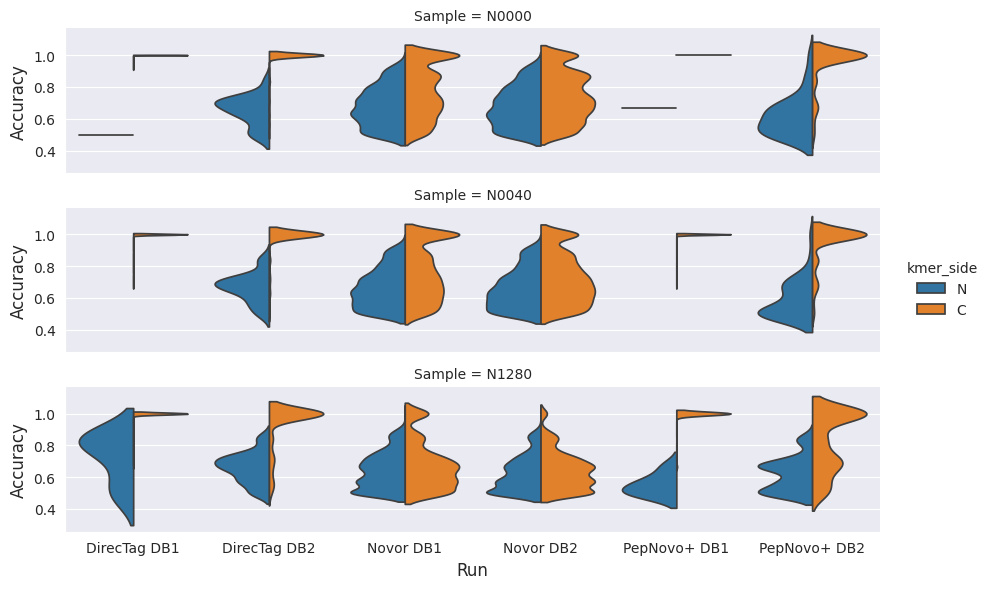

In [29]:
p1 = sns.catplot(
    data=denovo_aligns, row='Sample', kind='violin',
    x='Run settings', y='identity', hue='kmer_side', split=True, hue_order=['N', 'C'],
    density_norm='width', inner=None
)
p1.figure.set_size_inches((9,6))
p1.legend.set_bbox_to_anchor((1.1, 0.5))
p1.set_xlabels("Run", size=12)
p1.set_ylabels("Accuracy", size=12)
p1.figure.tight_layout()

p1.savefig(os.path.join(project, 'analysis_results', 'denovo_overall_acc.svg'), dpi=400)
p1.savefig(os.path.join(project, 'analysis_results', 'denovo_overall_acc.png'), dpi=400)


# Plot position identity average

In [30]:
# Pad identity vectors to max length
# Calculate avg identity per position identified
max_l = int(denovo_aligns['aligned_query'].str.len().max())
def pad_lists(posid, side):
    side = side[2]
    posid = posid.values
    if side == 'C':
        padded = np.array([np.pad(i, (max_l - len(i), 0), constant_values=-1) for i in posid])
    else: # side == 'N'
        padded = np.array([np.pad(i, (0, max_l - len(i)), constant_values=-1) for i in posid])
    # return padded[0]
    mask = np.zeros(padded.shape)
    mask[padded != -1 ] = 1
    padded[padded == -1] = 0
    pos_acc = np.sum(padded, axis=0) / np.sum(mask, axis=0)
    return pos_acc


In [31]:
position_acc_data = (
    denovo_aligns[denovo_aligns['pos_identity'].notnull()]
    .groupby(['Run_id', 'Sample', 'kmer_side'])
    .apply(lambda x: pad_lists(x.pos_identity, x.name)))

/tmp/ipykernel_447119/3516746326.py:15: RuntimeWarning: invalid value encountered in divide
  pos_acc = np.sum(padded, axis=0) / np.sum(mask, axis=0)


In [32]:
position_acc_data = position_acc_data.reset_index().rename(columns={0: 'pos_id'})
position_acc_data

,Run_id,Sample,kmer_side,pos_id
0,directag_db1,N0000,C,"[nan, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,directag_db1,N0000,N,"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
2,directag_db1,N0040,C,"[nan, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,directag_db1,N0040,N,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,directag_db1,N1280,C,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
5,directag_db1,N1280,N,"[1.0, 1.0, 1.0, 0.125, 0.625, 0.625, nan, nan,..."
6,directag_db2,N0000,C,"[nan, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,directag_db2,N0000,N,"[1.0, 1.0, 1.0, 0.6944444444444444, 0.55555555..."
8,directag_db2,N0040,C,"[nan, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
9,directag_db2,N0040,N,"[1.0, 1.0, 1.0, 0.7796610169491526, 0.38983050..."


In [33]:
# Unravel padded identity vector into columns
position_acc_data = pd.concat(
    [
        position_acc_data[['Run_id', 'Sample', 'kmer_side']],
        pd.DataFrame(position_acc_data['pos_id'].to_list(), columns = [f'identity{i}' for i in range(1,max_l+1)])
    ], axis=1
)
position_acc_data

,Run_id,Sample,kmer_side,identity1,identity2,identity3,identity4,identity5,identity6,identity7,...,identity19,identity20,identity21,identity22,identity23,identity24,identity25,identity26,identity27,identity28
0,directag_db1,N0000,C,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,directag_db1,N0000,N,1.0,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,directag_db1,N0040,C,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.997812,0.998026,0.997222,0.999074,1.000000,1.000000,1.000000,1.0
3,directag_db1,N0040,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,directag_db1,N1280,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.996795,0.995338,1.000000,0.994236,0.995677,1.000000,1.000000,1.000000,1.0
5,directag_db1,N1280,N,1.0,1.0,1.000000,0.125000,0.625000,0.625000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,directag_db2,N0000,C,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,0.993174,0.990769,0.989637,0.986143,0.980435,0.997826,0.990217,1.000000,1.000000,1.0
7,directag_db2,N0000,N,1.0,1.0,1.000000,0.694444,0.555556,0.305556,0.366667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,directag_db2,N0040,C,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,0.977716,0.969325,0.956067,0.931132,0.939207,0.989427,0.976211,1.000000,1.000000,1.0
9,directag_db2,N0040,N,1.0,1.0,1.000000,0.779661,0.389831,0.474576,0.369565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Pivot table from wide to long
position_acc_data = pd.wide_to_long(position_acc_data, stubnames='identity', i=['Run_id', 'Sample', 'kmer_side'], j='position').reset_index()
position_acc_data

,Run_id,Sample,kmer_side,position,identity
0,directag_db1,N0000,C,1,NaN
1,directag_db1,N0000,C,2,NaN
2,directag_db1,N0000,C,3,NaN
3,directag_db1,N0000,C,4,NaN
4,directag_db1,N0000,C,5,1.0
...,...,...,...,...,...
1003,pepnovo_db2,N1280,N,24,NaN
1004,pepnovo_db2,N1280,N,25,NaN
1005,pepnovo_db2,N1280,N,26,NaN
1006,pepnovo_db2,N1280,N,27,NaN


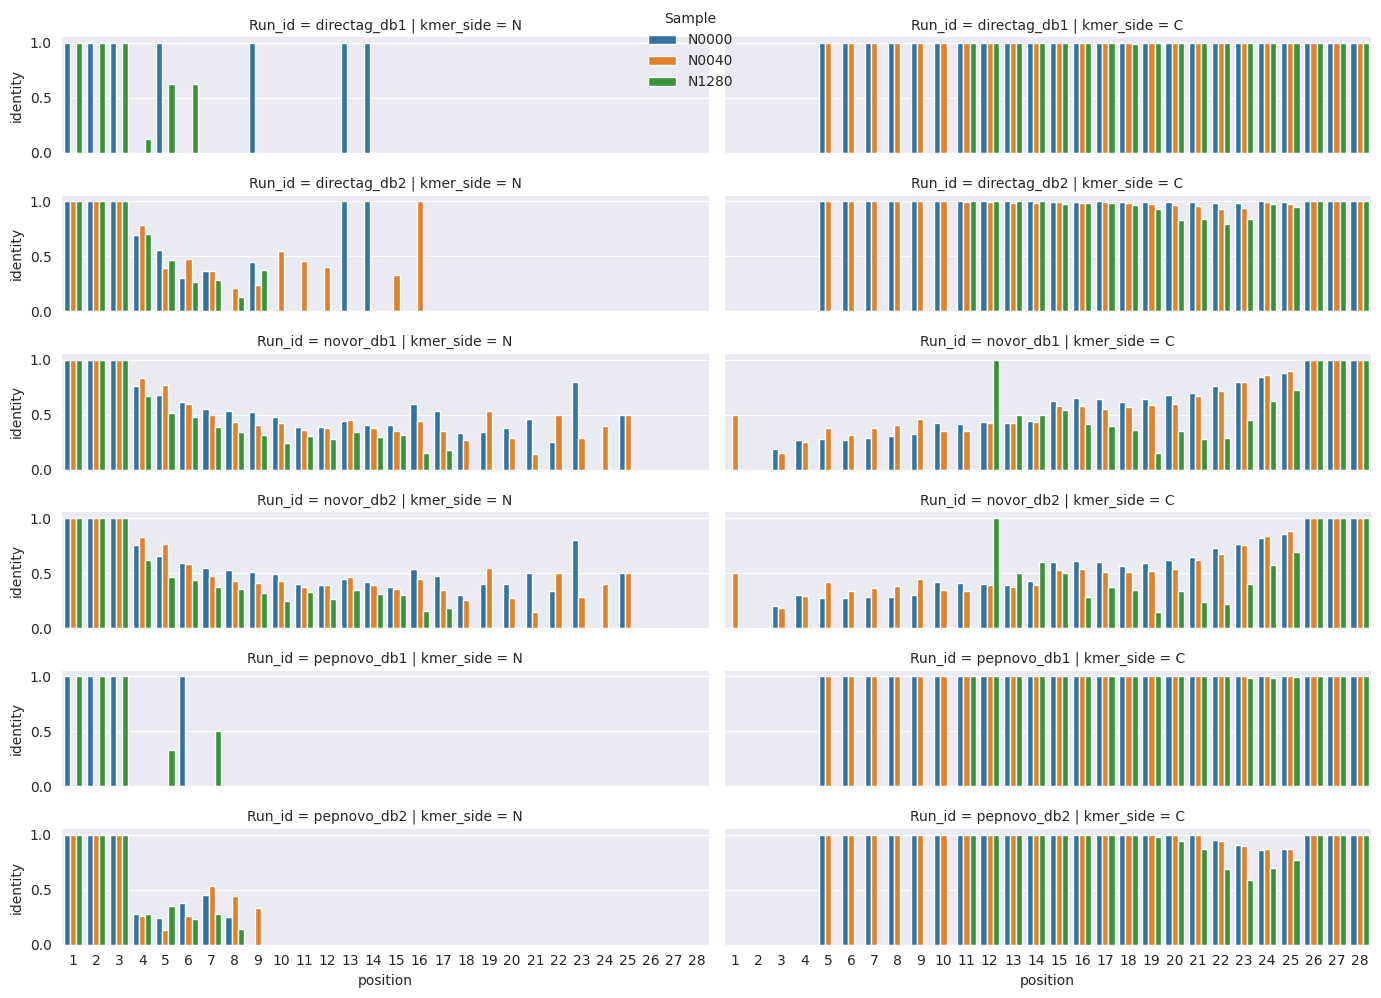

In [40]:
position_acc_data['identity'] = position_acc_data['identity'].fillna(0)

p2 = sns.catplot(
    data=position_acc_data,
    col='kmer_side', row='Run_id', kind='bar', hue='Sample',
    x='position', y='identity', errorbar=None, col_order=['N', 'C'],
    legend='brief'
)
sns.move_legend(p2, 'upper center')
p2.figure.set_size_inches((14,10))
p2.figure.tight_layout()